# Identify Potential Leads

## Problem Statement


A D2C startup develops products using **cutting edge technologies like Web 3.0**. Over the past few months, the company has started multiple **marketing campaigns** **offline** and **digital** both. As a result, the users have started showing interest in the product on the website. These users with intent to buy product(s) are generally known as leads (Potential Customers). 


Leads are captured in 2 ways - **Directly** and **Indirectly**. 


Direct leads are captured via forms embedded in the website while indirect leads are captured based on certain activity of a user on the platform such as time spent on the website, number of user sessions, etc.


Now, the marketing & sales team wants to identify the leads who are more likely to buy the product so that the sales team can manage their bandwidth efficiently by targeting these potential leads and increase the sales in a shorter span of time.


Now, as a data scientist, your task at hand is to **predict the propensity to buy a product based on the user's past activities and user level information**.

| Variable                        | Var Type  | Description                                                                 |
|---------------------------------|-----------|-----------------------------------------------------------------------------|
| **id**                          | *Nominal* | Unique identifier of a lead                                                 |
| **created_at**                  | *Date*    | Date of lead dropped                                                        |
| **signup_date**                 | *Date*    | Sign up date of the user on the website                                     |
| **campaign_var (1 and 2)**      | *Nominal* | campaign information of the lead                                            |
| **products_purchased**          | *Nominal* | No. of past products purchased at the time of dropping the lead             |
| **user_activity_var (1 to 12)** | *Nominal* | Derived activities of the user on the website                               |
| **buy**                         | *Boolean* | 0 or 1 indicating if the user will buy the product in next 3 months or not  |

## Import Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import IFrame
# from pandas_profiling import ProfileReport

from sklearn.model_selection import KFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,precision_recall_fscore_support as score
from sklearn.feature_selection import SelectKBest, chi2


# ML - Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Design Changes
import warnings
warnings.filterwarnings('ignore')

# Dataframe Values upto 2 decimals
pd.set_option("display.float_format", lambda x: '%.2f' % x)
# No limit on rows/column display
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

### Change some jupyter styles

In [2]:
%%html
<style>
table {float: left;}
table, th, tr, td {border: 1px solid #ccc !important}
</style>

## Import Data

In [3]:
# import data

data_dict = {
    'campaign_var_1': int, 'campaign_var_2': int, 'products_purchased': float, 
    'user_activity_var_1': int, 'user_activity_var_2': int, 'user_activity_var_3': int, 'user_activity_var_4': int, 'user_activity_var_5': int,
    'user_activity_var_6': int, 'user_activity_var_7': int, 'user_activity_var_8': int, 'user_activity_var_9': int, 'user_activity_var_10': int, 
    'user_activity_var_11': int, 'user_activity_var_12': int, 'buy': int}

train = pd.read_csv("../input/av-jobathon-jun2022/train_avj_june22.csv", 
                dtype = data_dict)

test = pd.read_csv("../input/av-jobathon-jun2022/test_avj_june22.csv", 
                dtype = data_dict)

train['created_at'] = pd.to_datetime(train['created_at'], format = '%Y-%m-%d')
train['signup_date'] = pd.to_datetime(train['signup_date'], format = '%Y-%m-%d')

test['created_at'] = pd.to_datetime(train['created_at'], format = '%Y-%m-%d')
test['signup_date'] = pd.to_datetime(train['signup_date'], format = '%Y-%m-%d')

train['products_purchased'] = train['products_purchased'].fillna(0).astype('Int64')
test['products_purchased'] = test['products_purchased'].fillna(0).astype('Int64')

## EDA

In [4]:
print("train:", train.shape)
print("test:", test.shape)

train: (39161, 19)
test: (13184, 18)


In [5]:
def freq(df, freq_list):
    freq_output = [
        pd.DataFrame({'dist': df[var].value_counts(dropna=False),
        '%': (df[var].value_counts(normalize=True, dropna=False)*100).round(1).astype(str) + ' %'
    }) for var in freq_list]
    
    return freq_output
        
freq(train, ["buy"])

[    dist       %
 0  37163  94.9 %
 1   1998   5.1 %]

The target variable looks **imbalanced** - will try to balance it using **oversample**

## Feature Engineering

### Observations:

The problem lacks a lot of key information - which makes it less science and more luck.
* There is no info about campaigns or user activity.
* Since there is no info about lead_drop date, we can't derive duration column on lead_drop or Subscribe date.
* Product purchase date could have been a very important feature

#### Plan (with whatever is available):
* The two date variables are of no use directly, will have to derive month, day, isweekend, etc.

In [6]:
# Derive new columns from Dates

train['created_month'] = train['created_at'].dt.month
train['created_day'] = train['created_at'].dt.day
train['created_qtr'] = train['created_at'].dt.quarter
train["created_weekday"] = train['created_at'].dt.dayofweek
train['created_yearhalf'] = np.where(train['created_at'].dt.month.le(6), 1, 2)
train["created_weekend"] = train['created_at'].dt.dayofweek > 4
train["created_weekend"] = train["created_weekend"].replace({True: 1, False: 0})

train['signup_date'].fillna(pd.to_datetime("2222-11-11 00:00:00"), inplace=True)

train['signup_month'] = train['signup_date'].dt.month
train['signup_day'] = train['signup_date'].dt.day
train['signup_qtr'] = train['signup_date'].dt.quarter
train["signup_weekday"] = train['signup_date'].dt.dayofweek
train['signup_yearhalf'] = np.where(train['signup_date'].dt.month.le(6), 1, 2)
train["signup_weekend"] = train['signup_date'].dt.dayofweek > 4
train["signup_weekend"] = train["signup_weekend"].replace({True: 1, False: 0})

test['created_month'] = test['created_at'].dt.month
test['created_day'] = test['created_at'].dt.day
test['created_qtr'] = test['created_at'].dt.quarter
test["created_weekday"] = test['created_at'].dt.dayofweek
test['created_yearhalf'] = np.where(test['created_at'].dt.month.le(6), 1, 2)
test["created_weekend"] = test['created_at'].dt.dayofweek > 4
test["created_weekend"] = test["created_weekend"].replace({True: 1, False: 0})

test['signup_date'].fillna(pd.to_datetime("2222-11-11 00:00:00"), inplace=True)

test['signup_month'] = test['signup_date'].dt.month
test['signup_day'] = test['signup_date'].dt.day
test['signup_qtr'] = test['signup_date'].dt.quarter
test["signup_weekday"] = test['signup_date'].dt.dayofweek
test['signup_yearhalf'] = np.where(test['signup_date'].dt.month.le(6), 1, 2)
test["signup_weekend"] = train['signup_date'].dt.dayofweek > 4
test["signup_weekend"] = test["signup_weekend"].replace({True: 1, False: 0})

In [7]:
train['user_activity_var_n1'] = np.where(train['user_activity_var_1']>0, 1, 0)
train['user_activity_var_n2'] = np.where(train['user_activity_var_2']>0, 1, 0)
train['user_activity_var_n3'] = np.where(train['user_activity_var_3']>0, 1, 0)
train['user_activity_var_n4'] = np.where(train['user_activity_var_4']>0, 1, 0)
train['user_activity_var_n5'] = np.where(train['user_activity_var_5']>0, 1, 0)
train['user_activity_var_n6'] = np.where(train['user_activity_var_6']>0, 1, 0)
train['user_activity_var_n7'] = np.where(train['user_activity_var_7']>0, 1, 0)
train['user_activity_var_n8'] = np.where(train['user_activity_var_8']>0, 1, 0)
train['user_activity_var_n9'] = np.where(train['user_activity_var_9']>0, 1, 0)
train['user_activity_var_n10'] = np.where(train['user_activity_var_10']>0, 1, 0)
train['user_activity_var_n11'] = np.where(train['user_activity_var_11']>0, 1, 0)
train['user_activity_var_n12'] = np.where(train['user_activity_var_12']>0, 1, 0)

train['user_activity_sum'] = (train['user_activity_var_n1'] + train['user_activity_var_n2'] + train['user_activity_var_n3'] + train['user_activity_var_n4'] +
    train['user_activity_var_n5'] + train['user_activity_var_n6'] + train['user_activity_var_n7'] + train['user_activity_var_n8'] +
    train['user_activity_var_n9'] + train['user_activity_var_n10'] + train['user_activity_var_n11'] + train['user_activity_var_n12'])

train["user_activity_weight"] = train['user_activity_sum'].apply(lambda x: 1 if ((x > 0) & (x <=6)) else 2 if ((x > 6) & (x <=12)) else 0)

test['user_activity_var_n1'] = np.where(test['user_activity_var_1']>0, 1, 0)
test['user_activity_var_n2'] = np.where(test['user_activity_var_2']>0, 1, 0)
test['user_activity_var_n3'] = np.where(test['user_activity_var_3']>0, 1, 0)
test['user_activity_var_n4'] = np.where(test['user_activity_var_4']>0, 1, 0)
test['user_activity_var_n5'] = np.where(test['user_activity_var_5']>0, 1, 0)
test['user_activity_var_n6'] = np.where(test['user_activity_var_6']>0, 1, 0)
test['user_activity_var_n7'] = np.where(test['user_activity_var_7']>0, 1, 0)
test['user_activity_var_n8'] = np.where(test['user_activity_var_8']>0, 1, 0)
test['user_activity_var_n9'] = np.where(test['user_activity_var_9']>0, 1, 0)
test['user_activity_var_n10'] = np.where(test['user_activity_var_10']>0, 1, 0)
test['user_activity_var_n11'] = np.where(test['user_activity_var_11']>0, 1, 0)
test['user_activity_var_n12'] = np.where(test['user_activity_var_12']>0, 1, 0)

test['user_activity_sum'] = (test['user_activity_var_n1'] + test['user_activity_var_n2'] + test['user_activity_var_n3'] + test['user_activity_var_n4'] +
    test['user_activity_var_n5'] + test['user_activity_var_n6'] + test['user_activity_var_n7'] + test['user_activity_var_n8'] +
    test['user_activity_var_n9'] + test['user_activity_var_n10'] + test['user_activity_var_n11'] + test['user_activity_var_n12'])

test["user_activity_weight"] = test['user_activity_sum'].apply(lambda x: 1 if ((x > 0) & (x <=6)) else 2 if ((x > 6) & (x <=12)) else 0)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     39161 non-null  int64         
 1   created_at             39161 non-null  datetime64[ns]
 2   campaign_var_1         39161 non-null  int64         
 3   campaign_var_2         39161 non-null  int64         
 4   products_purchased     39161 non-null  Int64         
 5   signup_date            39161 non-null  datetime64[ns]
 6   user_activity_var_1    39161 non-null  int64         
 7   user_activity_var_2    39161 non-null  int64         
 8   user_activity_var_3    39161 non-null  int64         
 9   user_activity_var_4    39161 non-null  int64         
 10  user_activity_var_5    39161 non-null  int64         
 11  user_activity_var_6    39161 non-null  int64         
 12  user_activity_var_7    39161 non-null  int64         
 13  u

In [9]:
# Drop columns that are not required anymore
train.drop(["created_at","signup_date", "user_activity_sum"] , axis=1, inplace=True)
test.drop(["created_at","signup_date", "user_activity_sum"] , axis=1, inplace=True)
train.drop(train.loc[:,train.columns.str.startswith('user_activity_var_n')], axis=1, inplace=True)
test.drop(test.loc[:,test.columns.str.startswith('user_activity_var_n')], axis=1, inplace=True)

## Visualisation

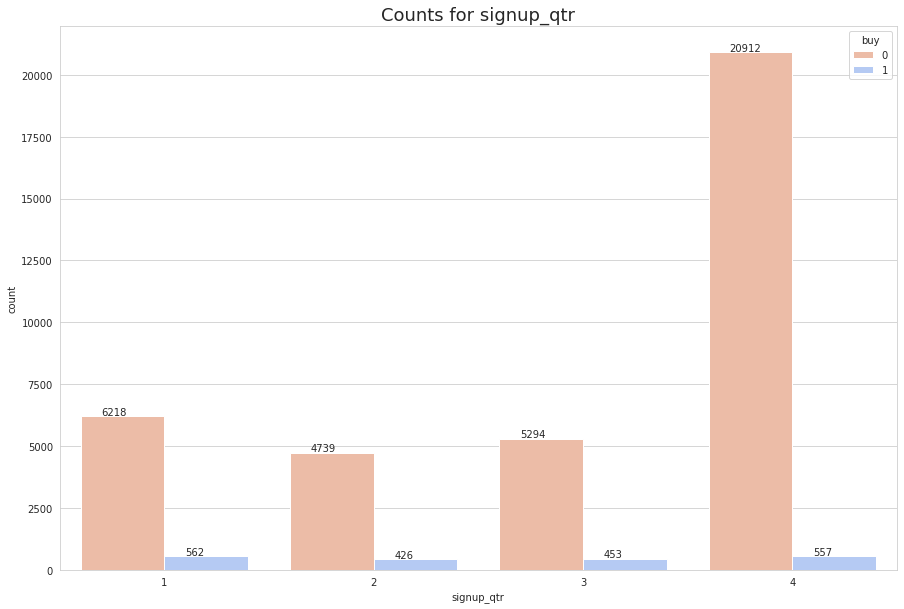

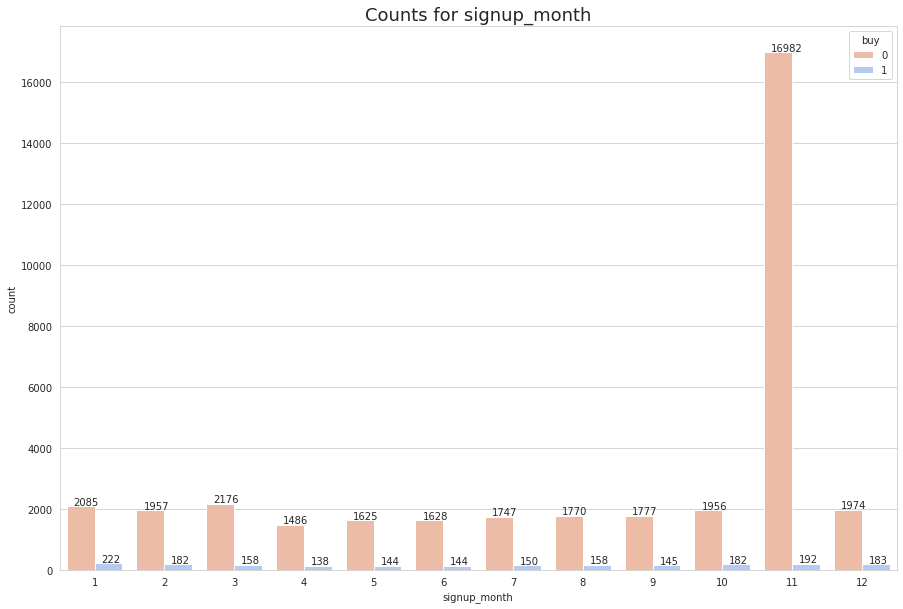

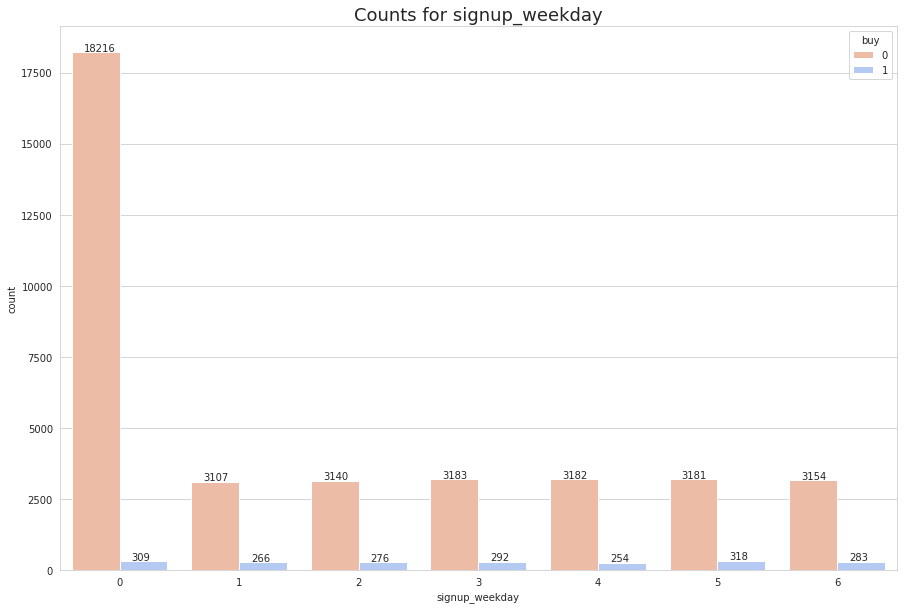

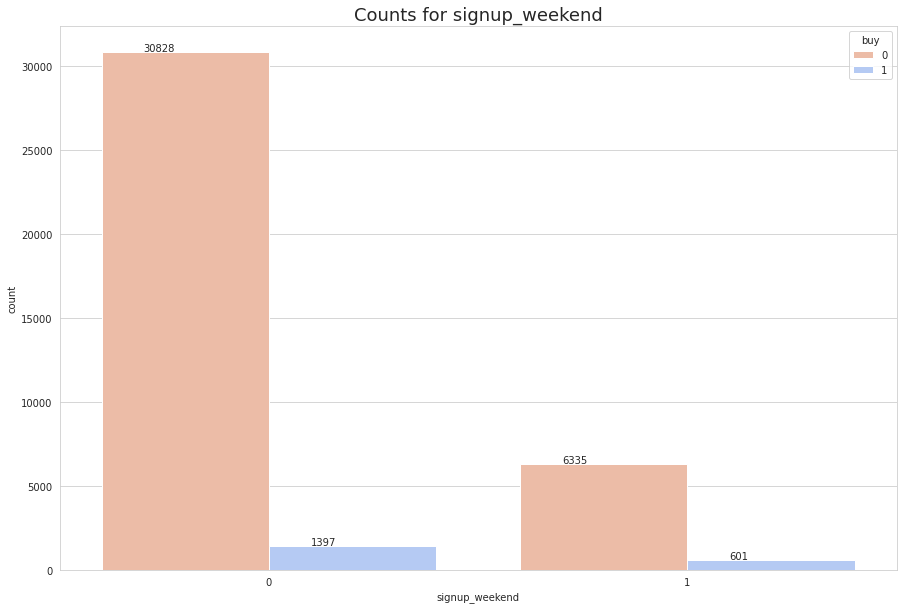

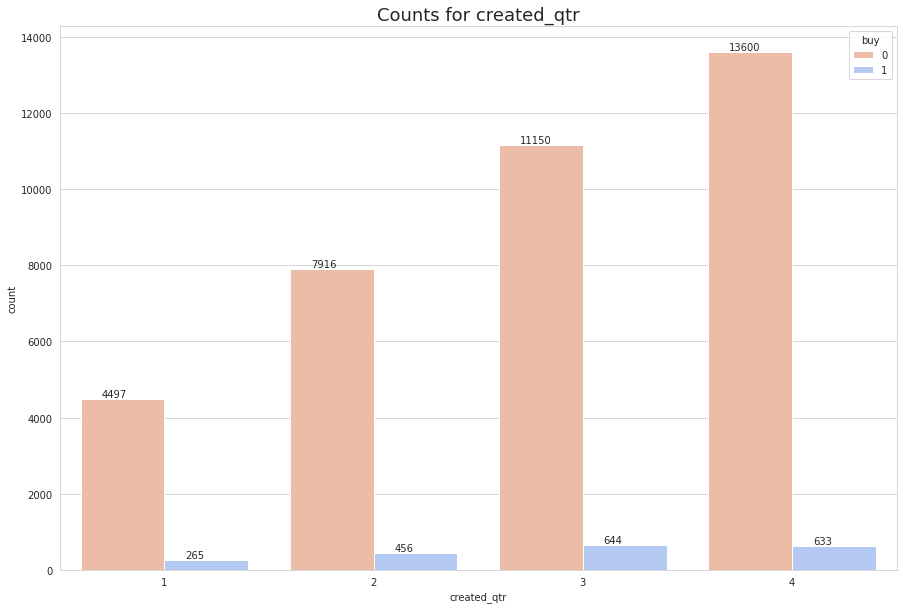

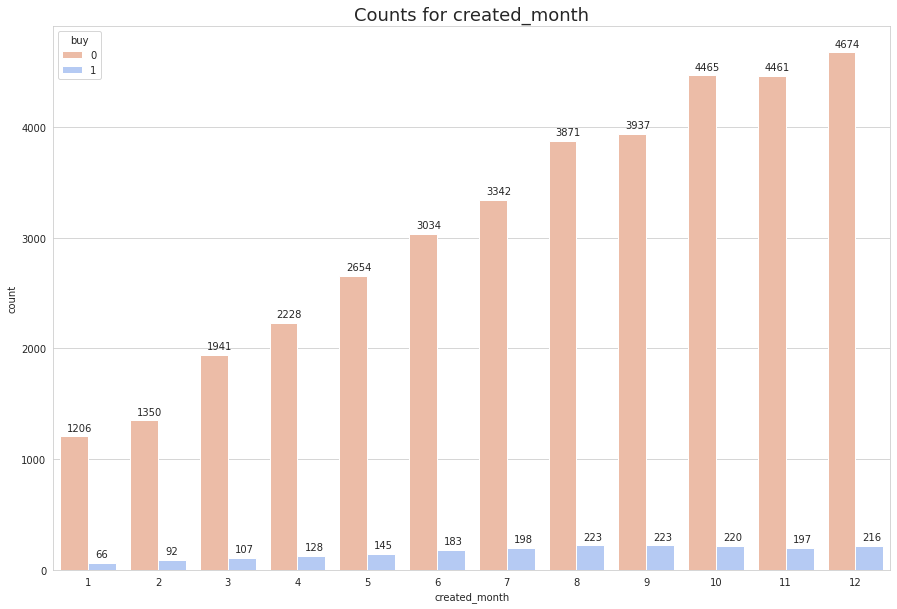

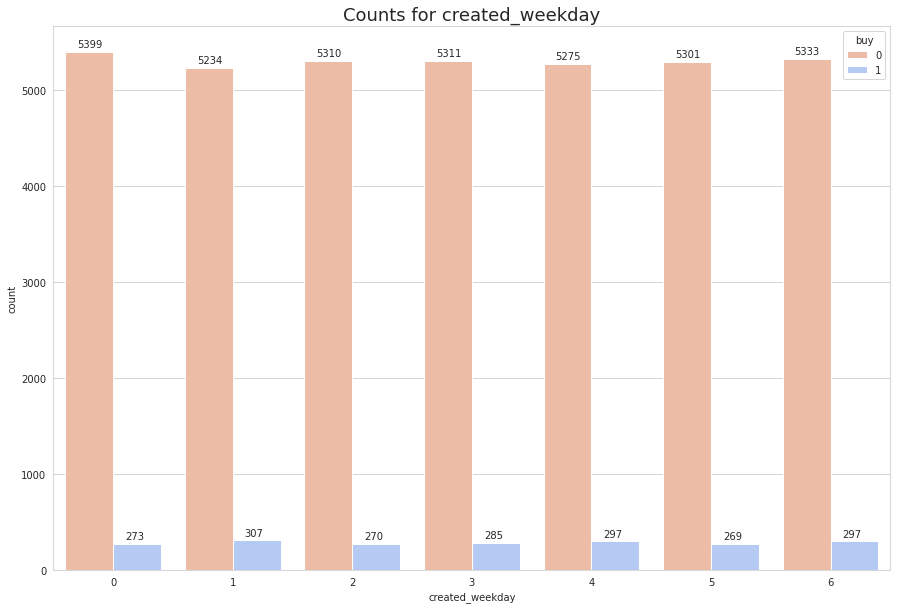

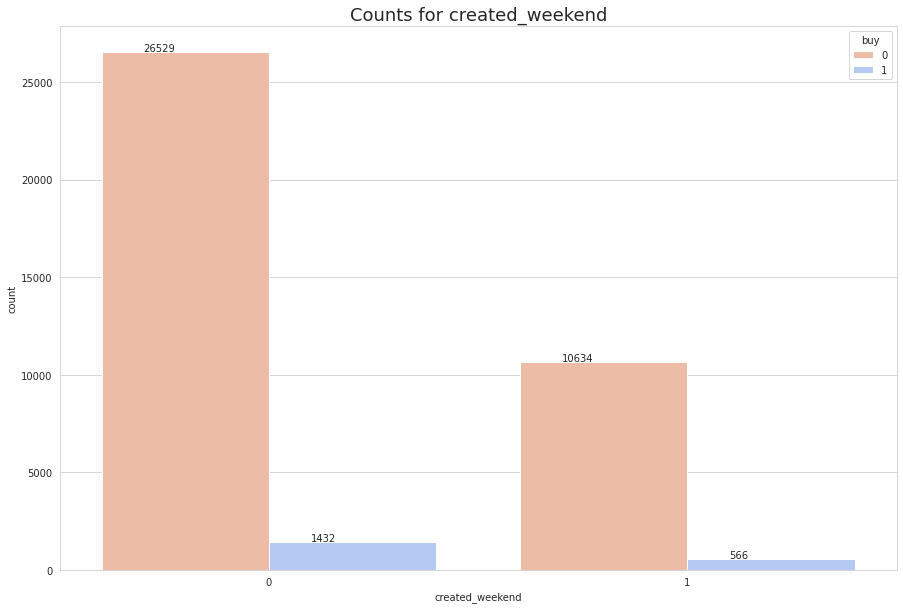

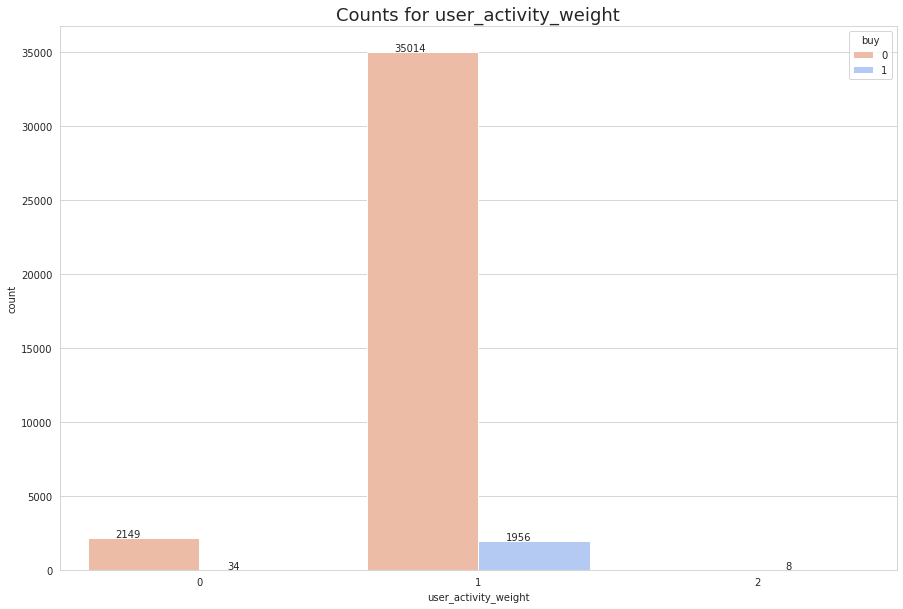

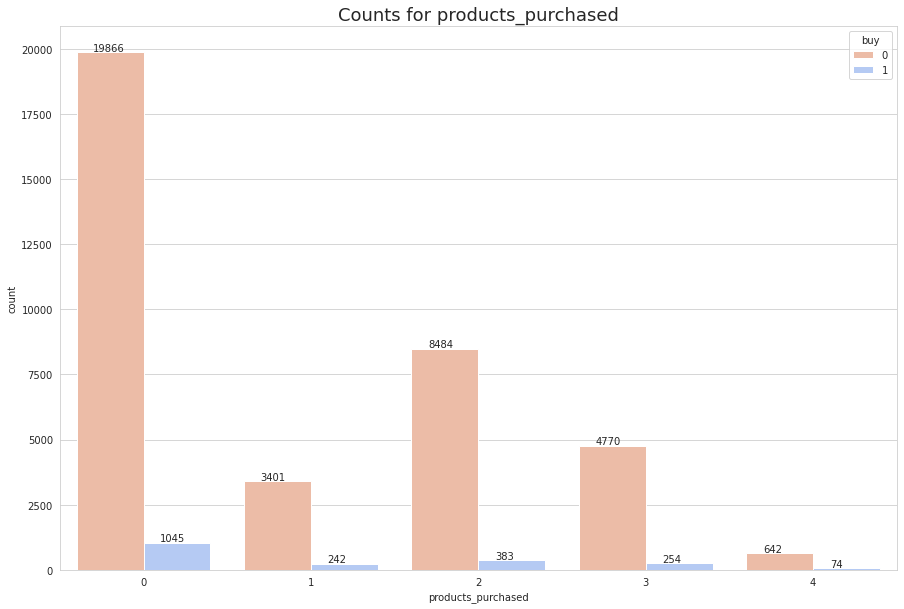

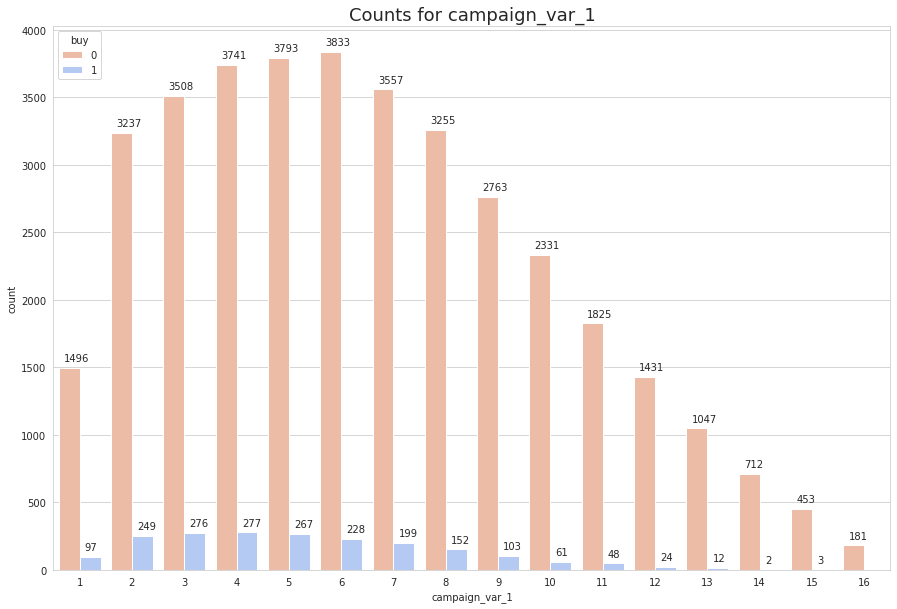

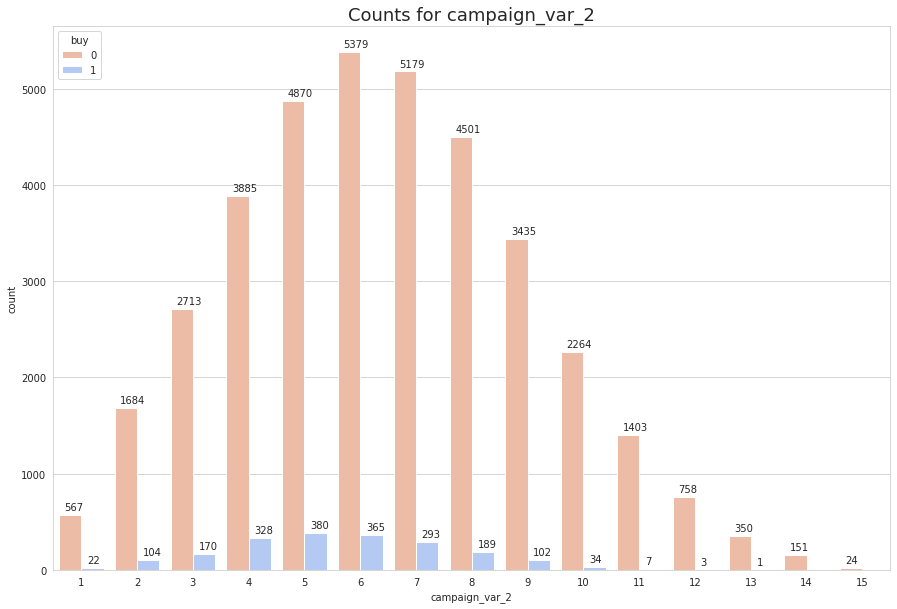

In [10]:
for i in ["signup_qtr", "signup_month", "signup_weekday", "signup_weekend", 
          "created_qtr", "created_month", "created_weekday", "created_weekend", 
          "user_activity_weight", "products_purchased", "campaign_var_1", "campaign_var_2"]:
    plt.figure(figsize=(15,10))

    ax = sns.countplot(x = i, hue = 'buy', data = train, palette = "coolwarm_r")
    plt.title(f'Counts for {i}', fontsize=18)
    
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    plt.show()

There is no clear trend for most of the variables. Mostly buy=0 or buy=1 is trending in a same way.

In [11]:
def distinct_val(cat_list):
    for col in cat_list:
        a = train[col].unique()
        print(col,":", np.sort(a),"\n")
distinct_val(['campaign_var_1', 'campaign_var_2',
              'products_purchased', 
              'user_activity_var_1', 'user_activity_var_2', 'user_activity_var_3', 'user_activity_var_4', 'user_activity_var_5', 
              'user_activity_var_6', 'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9', 'user_activity_var_10',
              'user_activity_var_11', 'user_activity_var_12',
#               'buy'
             ])

campaign_var_1 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 

campaign_var_2 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 

products_purchased : [0 1 2 3 4] 

user_activity_var_1 : [0 1 2 3] 

user_activity_var_2 : [0 1] 

user_activity_var_3 : [0 1] 

user_activity_var_4 : [0 1] 

user_activity_var_5 : [0 1 2] 

user_activity_var_6 : [0 1 2 3] 

user_activity_var_7 : [0 1 2] 

user_activity_var_8 : [0 1 2] 

user_activity_var_9 : [0 1] 

user_activity_var_10 : [0 1] 

user_activity_var_11 : [0 1 2 3 4] 

user_activity_var_12 : [0 1] 



In [12]:
def distinct_val(cat_list):
    for col in cat_list:
        a = test[col].unique()
        print(col,":", np.sort(a),"\n")
distinct_val(['campaign_var_1', 'campaign_var_2',
              'products_purchased', 
              'user_activity_var_1', 'user_activity_var_2', 'user_activity_var_3', 'user_activity_var_4', 'user_activity_var_5', 
              'user_activity_var_6', 'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9', 'user_activity_var_10',
              'user_activity_var_11', 'user_activity_var_12',
#               'buy'
             ])

campaign_var_1 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 

campaign_var_2 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 

products_purchased : [0 1 2 3 4] 

user_activity_var_1 : [0 1 2 3] 

user_activity_var_2 : [0 1] 

user_activity_var_3 : [0 1] 

user_activity_var_4 : [0 1] 

user_activity_var_5 : [0 1 2] 

user_activity_var_6 : [0 1 2 3] 

user_activity_var_7 : [0 1 2] 

user_activity_var_8 : [0 1 2] 

user_activity_var_9 : [0 1 2] 

user_activity_var_10 : [0 1] 

user_activity_var_11 : [0 1 2 3] 

user_activity_var_12 : [0 1] 



## Feature Selection

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(train.drop(["buy", "id"], axis=1), train["buy"])
feat_importances = pd.Series(model.feature_importances_, index=train.drop(["buy", "id"], axis=1).columns)
feat_importances.nlargest(10)

user_activity_var_9    0.17
user_activity_var_4    0.12
user_activity_var_11   0.09
user_activity_var_2    0.09
signup_day             0.05
created_day            0.04
campaign_var_1         0.04
campaign_var_2         0.04
signup_weekday         0.04
created_month          0.04
dtype: float64

In [14]:
chi2_features = SelectKBest(chi2, k = 10) 
X_kbest_features = chi2_features.fit_transform(train.drop(["buy", "id"], axis=1), train["buy"])
mask=chi2_features.get_support()
new_feature=[]
for bool,feature in zip(mask,train.drop(["buy", "id"], axis=1).columns):
    if bool:
        new_feature.append(feature)
list3=new_feature
list3

['campaign_var_1',
 'user_activity_var_2',
 'user_activity_var_4',
 'user_activity_var_5',
 'user_activity_var_8',
 'user_activity_var_9',
 'user_activity_var_11',
 'signup_month',
 'signup_day',
 'signup_weekday']

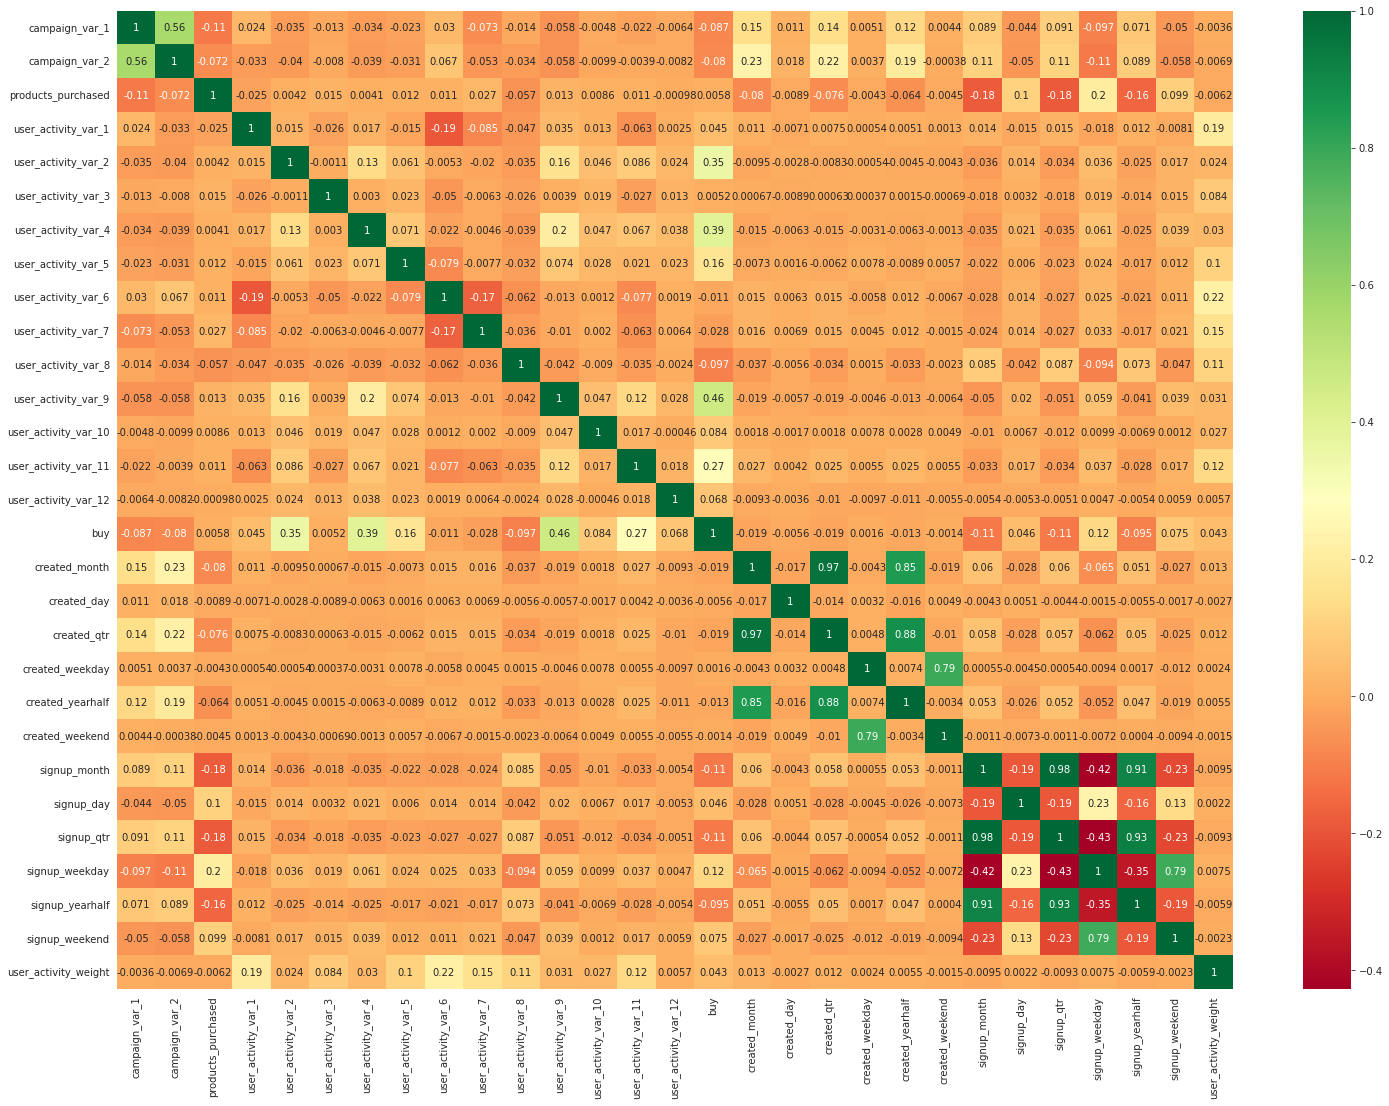

In [15]:
# get correlations of each features in dataset
corrmat = train.drop(["id"], axis=1).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,18))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Selecting the variables having high correlation (>.1) with the target variable

In [16]:
X = train.loc[:,["user_activity_var_11", "user_activity_var_9", "user_activity_var_4", "user_activity_var_2", 
                 "user_activity_var_5", "user_activity_var_8"]]
y = train.loc[:,"buy"]
y_sub_train= test.loc[:,["user_activity_var_11", "user_activity_var_9", "user_activity_var_4", "user_activity_var_2", 
                 "user_activity_var_5", "user_activity_var_8"]]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state = 99)

In [18]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred_gbc = gbc.predict(X_test)

In [19]:
# Calculate f score
def acc(list_):
    for i in list_:
        print(f1_score(i[0], i[1]))

acc([[y_pred_lr, y_test]])
acc([[y_pred_dtc, y_test]])
acc([[y_pred_rfc, y_test]]) # highest
acc([[y_pred_svc, y_test]])
acc([[y_pred_knn, y_test]])
acc([[y_pred_gnb, y_test]])
acc([[y_pred_gbc, y_test]])

0.6329625884732053
0.6790243902439024
0.6790243902439024
0.6790243902439024
0.6510681586978637
0.6
0.6790243902439024


* Following algorithm is giving the highest f score: **dtc**, **rfc**, **svc**, **gbc**
* Will try hyperparameter tuning for these 4.

In [20]:
# DTC
parameters={"splitter":["best","random"],
            "max_depth" : [4, 6, 8],
           "min_samples_leaf":[3, 4, 5, 6],
           "min_weight_fraction_leaf":[0, 0.05, 0.1, 0.2],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None, 90,100,110] }

tuning_model=RandomizedSearchCV(estimator=DecisionTreeClassifier(),param_distributions=parameters,scoring='neg_mean_squared_error',cv=50,verbose=1)
result_dtc = tuning_model.fit(X, y)
tuning_model.best_params_

Fitting 50 folds for each of 10 candidates, totalling 500 fits


{'splitter': 'best',
 'min_weight_fraction_leaf': 0,
 'min_samples_leaf': 5,
 'max_leaf_nodes': None,
 'max_features': None,
 'max_depth': 8}

In [21]:
# SVC

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 
              'C':[5, 10, 15, 20],
              'gamma':[1, 0.1, 0.01, 0.001]
             }
tune_svc = RandomizedSearchCV(estimator=SVC(), param_distributions=parameters)
result = tune_svc.fit(X, y)

result.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 15}

In [22]:
params = {
    "n_estimators":[500,600,700,800],
    "max_depth":[2,4,6],
    "learning_rate":[0.1, 0.01, 0.001]
}
CV_gbc = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=params)
result = CV_gbc.fit(X, y)
result.best_params_

{'n_estimators': 600, 'max_depth': 2, 'learning_rate': 0.1}

In [23]:
#RFC

parameters ={'max_depth': [30,40,50,60],
     'criterion' : ['entropy', 'gini'],
     'max_features': [0.40, 0.45, 0.50, 0.55],
     'min_samples_leaf': [4, 6, 8],
     'min_samples_split': [6, 8, 10],
     'n_estimators': [90,95,100,110]}

random_search=RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parameters, verbose=1, n_jobs=-1, n_iter=50)
random_result = random_search.fit(X, y)
random_result.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'n_estimators': 90,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 0.45,
 'max_depth': 60,
 'criterion': 'gini'}

In [24]:
# Fitting the tuned parameters

dtc = DecisionTreeClassifier(splitter='random', min_weight_fraction_leaf=0.1, min_samples_leaf=4, max_leaf_nodes=90, max_features='auto', max_depth=8)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

rfc = RandomForestClassifier(n_estimators=95, min_samples_split=8, min_samples_leaf=4, max_features=.4, max_depth=50, criterion='entropy')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

svc = SVC(kernel='rbf', gamma=1, C=15)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

gbc = GradientBoostingClassifier(n_estimators=500,max_depth=2, learning_rate=0.1)
gbc.fit(X_train,y_train)
y_pred_gbc = gbc.predict(X_test)

acc([[y_pred_dtc, y_test]])
acc([[y_pred_rfc, y_test]])
acc([[y_pred_svc, y_test]])
acc([[y_pred_gbc, y_test]])

0.0
0.6738491674828598
0.6790243902439024
0.6796875


highest f-score is of GBC = 0.6796875, hence this will be the final model

In [25]:
y_pred_svc.shape

(12924,)

In [26]:
df = X_test.copy()
df["pred"] = y_pred_gbc
df["buy"] = y_test

In [27]:
df.shape

(12924, 8)

In [28]:
df.pred.value_counts()

0    12559
1      365
Name: pred, dtype: int64

In [29]:
df.buy.value_counts()

0    12265
1      659
Name: buy, dtype: int64

In [30]:
df[df["pred"]!=df["buy"]]

,user_activity_var_11,user_activity_var_9,user_activity_var_4,user_activity_var_2,user_activity_var_5,user_activity_var_8,pred,buy
17554,1,0,0,0,0,0,0,1
16892,1,0,0,0,1,0,0,1
10035,1,0,0,0,0,0,0,1
12540,1,0,0,0,0,0,0,1
26617,0,0,0,0,0,0,0,1
26967,0,0,0,0,0,0,0,1
34857,0,0,0,0,0,1,0,1
13428,1,0,0,0,1,0,0,1
25377,1,0,0,0,0,0,0,1
1686,1,0,0,0,1,0,0,1


In [31]:
# Create df and export for submission

# from datetime import datetime
# import pytz
# IST = pytz.timezone('Asia/Kolkata')
# cur_time = datetime.now(IST).strftime("%H_%M_%S")

# y_pred_dtc = gbc.predict(y_sub_train)
# submission_df = test[["id"]]
# submission_df["buy"] = y_pred_dtc

# submission_df.to_csv(f"submission_rfc_{cur_time}.csv", index=False)